<a href="https://colab.research.google.com/github/sparsh-ai/reco-book/blob/stage/nbs/T536348_Attention_Mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [2]:
!pip install -q d2l==0.17.0

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from d2l import torch as d2l

## Attention Pooling

In [ ]:
n_train = 50  # No. of training examples
x_train, _ = torch.sort(torch.rand(n_train) * 5)  # Training inputs


def f(x):
    """yi=2sin(xi)+x0.8i+ϵ"""
    return 2 * torch.sin(x) + x**0.8


y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # Training outputs
x_test = torch.arange(0, 5, 0.1)  # Testing examples
y_truth = f(x_test)  # Ground-truth outputs for the testing examples
n_test = len(x_test)  # No. of testing examples


def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

### Average Pooling

We begin with perhaps the world's "dumbest" estimator for this regression problem:
using average pooling to average over all the training outputs:

$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$

which is plotted below. As we can see, this estimator is indeed not so smart.


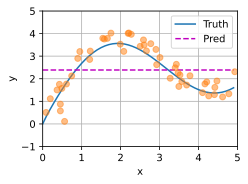

In [ ]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

### Nonparametric Attention Pooling

Obviously, average pooling omits the inputs  xi . A better idea was proposed by Nadaraya [Nadaraya, 1964] and Watson [Watson, 1964] to weigh the outputs  yi  according to their input locations:

$$ \begin{split}\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}\end{split} $$

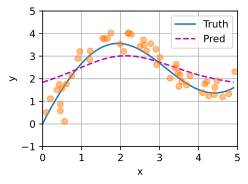

In [ ]:
# Shape of `X_repeat`: (`n_test`, `n_train`), where each row contains the
# same testing inputs (i.e., same queries)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# Note that `x_train` contains the keys. Shape of `attention_weights`:
# (`n_test`, `n_train`), where each row contains attention weights to be
# assigned among the values (`y_train`) given each query
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# Each element of `y_hat` is weighted average of values, where weights are
# attention weights
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

Now let us take a look at the attention weights. Here testing inputs are queries while training inputs are keys. Since both inputs are sorted, we can see that the closer the query-key pair is, the higher attention weight is in the attention pooling.

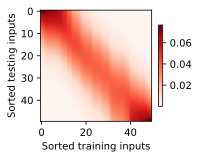

In [ ]:
d2l.show_heatmaps(
    attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

### Parametric Attention Pooling

Nonparametric Nadaraya-Watson kernel regression enjoys the consistency benefit: given enough data this model converges to the optimal solution. Nonetheless, we can easily integrate learnable parameters into attention pooling.

As an example, slightly different from the above, in the following the distance between the query  x  and the key  xi  is multiplied by a learnable parameter  w :

$$ \begin{split}\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}\end{split} $$

> Note: In the context of attention mechanisms, we can use minibatch matrix multiplication to compute weighted averages of values in a minibatch.

In [ ]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

Using minibatch matrix multiplication, below we define the parametric version of Nadaraya-Watson kernel regression based on the parametric attention pooling:

In [ ]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # Shape of the output `queries` and `attention_weights`:
        # (no. of queries, no. of key-value pairs)
        queries = queries.repeat_interleave(keys.shape[1]).reshape(
            (-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # Shape of `values`: (no. of queries, no. of key-value pairs)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In the following, we transform the training dataset to keys and values to train the attention model. In the parametric attention pooling, any training input takes key-value pairs from all the training examples except for itself to predict its output.

In [ ]:
# Shape of `X_tile`: (`n_train`, `n_train`), where each column contains the
# same training inputs
X_tile = x_train.repeat((n_train, 1))
# Shape of `Y_tile`: (`n_train`, `n_train`), where each column contains the
# same training outputs
Y_tile = y_train.repeat((n_train, 1))
# Shape of `keys`: ('n_train', 'n_train' - 1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))
# Shape of `values`: ('n_train', 'n_train' - 1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))

Using the squared loss and stochastic gradient descent, we train the parametric attention model.

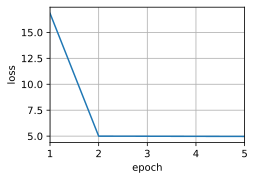

In [ ]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    # Note: L2 Loss = 1/2 * MSE Loss. PyTorch has MSE Loss which is slightly
    # different from MXNet's L2Loss by a factor of 2. Hence we halve the loss
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

After training the parametric attention model, we can plot its prediction. Trying to fit the training dataset with noise, the predicted line is less smooth than its nonparametric counterpart that was plotted earlier.

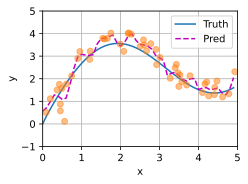

In [ ]:
# Shape of `keys`: (`n_test`, `n_train`), where each column contains the same
# training inputs (i.e., same keys)
keys = x_train.repeat((n_test, 1))
# Shape of `value`: (`n_test`, `n_train`)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

Comparing with nonparametric attention pooling, the region with large attention weights becomes sharper in the learnable and parametric setting.

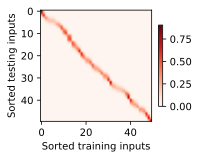

In [ ]:
d2l.show_heatmaps(
    net.attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

## Attention Scoring Functions

### Masked Softmax Operation

A softmax operation is used to output a probability distribution as attention weights. In some cases, not all the values should be fed into attention pooling. For instance, for efficient minibatch processing, some text sequences are padded with special tokens that do not carry meaning. To get an attention pooling over only meaningful tokens as values, we can specify a valid sequence length (in number of tokens) to filter out those beyond this specified range when computing softmax. In this way, we can implement such a masked softmax operation in the following masked_softmax function, where any value beyond the valid length is masked as zero.

In [ ]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

To demonstrate how this function works, consider a minibatch of two  2×4  matrix examples, where the valid lengths for these two examples are two and three, respectively. As a result of the masked softmax operation, values beyond the valid lengths are all masked as zero.

In [ ]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.3860, 0.6140, 0.0000, 0.0000],
         [0.3940, 0.6060, 0.0000, 0.0000]],

        [[0.3661, 0.3699, 0.2640, 0.0000],
         [0.4437, 0.1879, 0.3684, 0.0000]]])

Similarly, we can also use a two-dimensional tensor to specify valid lengths for every row in each matrix example.

In [ ]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2764, 0.3095, 0.4141, 0.0000]],

        [[0.4474, 0.5526, 0.0000, 0.0000],
         [0.1812, 0.2268, 0.2735, 0.3184]]])

### Additive Attention
In general, when queries and keys are vectors of different lengths, we can use additive attention as the scoring function. Given a query q and a key k, the additive attention scoring function:

$$ a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R}, $$

The query and the key are concatenated and fed into an MLP with a single hidden layer whose number of hidden units is  h , a hyperparameter. By using  tanh  as the activation function and disabling bias terms, we implement additive attention in the following.

In [ ]:
class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of `queries`: (`batch_size`, no. of
        # queries, 1, `num_hiddens`) and shape of `keys`: (`batch_size`, 1,
        # no. of key-value pairs, `num_hiddens`). Sum them up with
        # broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of `self.w_v`, so we remove the last
        # one-dimensional entry from the shape. Shape of `scores`:
        # (`batch_size`, no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of `values`: (`batch_size`, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

Let us demonstrate the above AdditiveAttention class with a toy example, where shapes (batch size, number of steps or sequence length in tokens, feature size) of queries, keys, and values are ( 2 ,  1 ,  20 ), ( 2 ,  10 ,  2 ), and ( 2 ,  10 ,  4 ), respectively. The attention pooling output has a shape of (batch size, number of steps for queries, feature size for values).

In [ ]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# The two value matrices in the `values` minibatch are identical
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

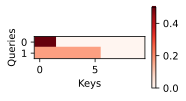

In [ ]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

### Scaled Dot-Product Attention
A more computationally efficient design for the scoring function can be simply dot product. However, the dot product operation requires that both the query and the key have the same vector length, say d. Assume that all the elements of the query and the key are independent random variables with zero mean and unit variance. The dot product of both vectors has zero mean and a variance of d.

In practice, we often think in minibatches for efficiency, such as computing attention for n queries and m key-value pairs, where queries and keys are of length d and values are of length v. The scaled dot-product attention of queries Q, keys K, and values V is:

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}. $$

In the following implementation of the scaled dot product attention, we use dropout for model regularization.

In [ ]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Set `transpose_b=True` to swap the last two dimensions of `keys`
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

To demonstrate the above DotProductAttention class, we use the same keys, values, and valid lengths from the earlier toy example for additive attention. For the dot product operation, we make the feature size of queries the same as that of keys.

In [ ]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

Same as in the additive attention demonstration, since keys contains the same element that cannot be differentiated by any query, uniform attention weights are obtained.

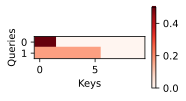

In [ ]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

### Bahdanau Attention

$$ \mathbf{c}_{t'} = \sum_{t=1}^T \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_t) \mathbf{h}_t, $$

where the decoder hidden state  st′−1 at time step t′−1 is the query, and the encoder hidden states ht are both the keys and values, and the attention weight α is computed using the additive attention scoring function.

To implement the RNN encoder-decoder with Bahdanau attention, we only need to redefine the decoder. To visualize the learned attention weights more conveniently, the following AttentionDecoder class defines the base interface for decoders with attention mechanisms.

In [ ]:
class AttentionDecoder(d2l.Decoder):
    """The base attention-based decoder interface."""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

Now let us implement the RNN decoder with Bahdanau attention in the following Seq2SeqAttentionDecoder class. The state of the decoder is initialized with (i) the encoder final-layer hidden states at all the time steps (as keys and values of the attention); (ii) the encoder all-layer hidden state at the final time step (to initialize the hidden state of the decoder); and (iii) the encoder valid length (to exclude the padding tokens in attention pooling). At each decoding time step, the decoder final-layer hidden state at the previous time step is used as the query of the attention. As a result, both the attention output and the input embedding are concatenated as the input of the RNN decoder.

In [ ]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(num_hiddens, num_hiddens,
                                               num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # Shape of `outputs`: (`num_steps`, `batch_size`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output `X`: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of `query`: (`batch_size`, 1, `num_hiddens`)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of `context`: (`batch_size`, 1, `num_hiddens`)
            context = self.attention(query, enc_outputs, enc_outputs,
                                     enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape `x` as (1, `batch_size`, `embed_size` + `num_hiddens`)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully-connected layer transformation, shape of `outputs`:
        # (`num_steps`, `batch_size`, `vocab_size`)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [
            enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In the following, we test the implemented decoder with Bahdanau attention using a minibatch of 4 sequence inputs of 7 time steps.

In [ ]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (`batch_size`, `num_steps`)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

We specify hyperparemeters, instantiate an encoder and a decoder with Bahdanau attention, and train this model for machine translation. Due to the newly added attention mechanism, this training is much slower.

loss 0.020, 4689.9 tokens/sec on cpu


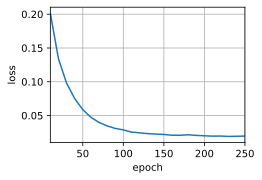

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens,
                             num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens,
                                  num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

After the model is trained, we use it to translate a few English sentences into French and compute their BLEU scores.

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est bon .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


By visualizing the attention weights when translating the last English sentence, we can see that each query assigns non-uniform weights over key-value pairs. It shows that at each decoding step, different parts of the input sequences are selectively aggregated in the attention pooling.

In [ ]:
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weight_seq], 0).reshape(
        (1, 1, -1, num_steps))

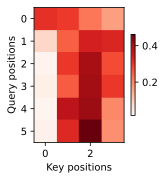

In [ ]:
# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

### Multi-Head Attention

In practice,
given the same set of queries, keys, and values
we may want our model to
combine knowledge from
different behaviors of the same attention mechanism,
such as capturing dependencies of various ranges (e.g., shorter-range vs. longer-range)
within a sequence.
Thus, 
it may be beneficial 
to allow our attention mechanism
to jointly use different representation subspaces
of queries, keys, and values.



To this end,
instead of performing a single attention pooling,
queries, keys, and values
can be transformed
with $h$ independently learned linear projections.
Then these $h$ projected queries, keys, and values
are fed into attention pooling in parallel.
In the end,
$h$ attention pooling outputs
are concatenated and 
transformed with another learned linear projection
to produce the final output.
This design
is called *multi-head attention*,
where each of the $h$ attention pooling outputs
is a *head*.
Using fully-connected layers
to perform learnable linear transformations.

Before providing the implementation of multi-head attention,
let us formalize this model mathematically.
Given a query $\mathbf{q} \in \mathbb{R}^{d_q}$,
a key $\mathbf{k} \in \mathbb{R}^{d_k}$,
and a value $\mathbf{v} \in \mathbb{R}^{d_v}$,
each attention head $\mathbf{h}_i$  ($i = 1, \ldots, h$)
is computed as

$$\mathbf{h}_i = f(\mathbf W_i^{(q)}\mathbf q, \mathbf W_i^{(k)}\mathbf k,\mathbf W_i^{(v)}\mathbf v) \in \mathbb R^{p_v},$$

where learnable parameters
$\mathbf W_i^{(q)}\in\mathbb R^{p_q\times d_q}$,
$\mathbf W_i^{(k)}\in\mathbb R^{p_k\times d_k}$
and $\mathbf W_i^{(v)}\in\mathbb R^{p_v\times d_v}$,
and
$f$ is attention pooling,
such as
additive attention and scaled dot-product attention.
The multi-head attention output
is another linear transformation via 
learnable parameters
$\mathbf W_o\in\mathbb R^{p_o\times h p_v}$
of the concatenation of $h$ heads:

$$\mathbf W_o \begin{bmatrix}\mathbf h_1\\\vdots\\\mathbf h_h\end{bmatrix} \in \mathbb{R}^{p_o}.$$

Based on this design,
each head may attend to different parts of the input.
More sophisticated functions than the simple weighted average
can be expressed.


In our implementation,
we **choose the scaled dot-product attention
for each head** of the multi-head attention.
To avoid significant growth
of computational cost and parameterization cost,
we set
$p_q = p_k = p_v = p_o / h$.
Note that $h$ heads
can be computed in parallel
if we set
the number of outputs of linear transformations
for the query, key, and value
to $p_q h = p_k h = p_v h = p_o$.
In the following implementation,
$p_o$ is specified via the argument `num_hiddens`.


In [ ]:
class MultiHeadAttention(nn.Module):
    """Multi-head attention."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of `queries`, `keys`, or `values`:
        # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`)
        # Shape of `valid_lens`:
        # (`batch_size`,) or (`batch_size`, no. of queries)
        # After transposing, shape of output `queries`, `keys`, or `values`:
        # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
        # `num_hiddens` / `num_heads`)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for
            # `num_heads` times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(valid_lens,
                                                 repeats=self.num_heads,
                                                 dim=0)

        # Shape of `output`: (`batch_size` * `num_heads`, no. of queries,
        # `num_hiddens` / `num_heads`)
        output = self.attention(queries, keys, values, valid_lens)

        # Shape of `output_concat`:
        # (`batch_size`, no. of queries, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

To allow for parallel computation of multiple heads, the above MultiHeadAttention class uses two transposition functions as defined below. Specifically, the transpose_output function reverses the operation of the transpose_qkv function.

In [ ]:
def transpose_qkv(X, num_heads):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`).
    # Shape of output `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_heads`,
    # `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # Shape of output `X`:
    # (`batch_size`, `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    X = X.permute(0, 2, 1, 3)

    # Shape of `output`:
    # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """Reverse the operation of `transpose_qkv`."""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

Let us test our implemented MultiHeadAttention class using a toy example where keys and values are the same. As a result, the shape of the multi-head attention output is (batch_size, num_queries, num_hiddens).

In [ ]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [ ]:
batch_size, num_queries, num_kvpairs, valid_lens = 2, 4, 6, torch.tensor([
    3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

## Basic Attention

In this section, we look at how attention is implemented. We will focus on implementing attention in isolation from a larger model. That's because when implementing attention in a real-world model, a lot of the focus goes into piping the data and juggling the various vectors rather than the concepts of attention themselves.

We will implement attention scoring as well as calculating an attention context vector.

Let's start by looking at the inputs we'll give to the scoring function. We will assume we're in the first step in the decoding phase. The first input to the scoring function is the hidden state of decoder (assuming a toy RNN with three hidden nodes -- not usable in real life, but easier to illustrate):

In [4]:
dec_hidden_state = [5,1,20]

Let's visualize this vector:

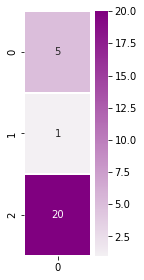

In [5]:
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(dec_hidden_state)), annot=True, cmap=sns.light_palette("purple", as_cmap=True), linewidths=1)
plt.show()

Our first scoring function will score a single annotation (encoder hidden state), which looks like this:

In [6]:
annotation = [3,12,45] #e.g. Encoder hidden state

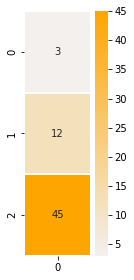

In [8]:
# Let's visualize the single annotation
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(annotation)), annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)
plt.show()

Let's calculate the dot product of a single annotation. NumPy's [dot()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) is a good candidate for this operation

In [9]:
def single_dot_attention_score(dec_hidden_state, enc_hidden_state):
    # TODO: return the dot product of the two vectors
    return np.dot(dec_hidden_state, enc_hidden_state)
    
single_dot_attention_score(dec_hidden_state, annotation)

927

Let's now look at scoring all the annotations at once. To do that, here's our annotation matrix:

In [10]:
annotations = np.transpose([[3,12,45], [59,2,5], [1,43,5], [4,3,45.3]])

And it can be visualized like this (each column is a hidden state of an encoder time step):

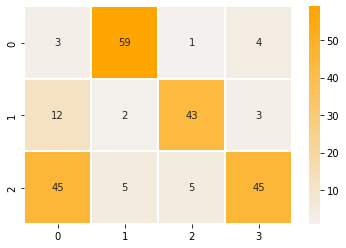

In [11]:
# Let's visualize our annotation (each column is an annotation)
ax = sns.heatmap(annotations, annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)
plt.show()

Let's calculate the scores of all the annotations in one step using matrix multiplication. Let's continue to use the dot scoring method

To do that, we'll have to transpose `dec_hidden_state` and [matrix multiply](https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html) it with `annotations`.

In [12]:
def dot_attention_score(dec_hidden_state, annotations):
    # TODO: return the product of dec_hidden_state transpose and enc_hidden_states
    return np.matmul(np.transpose(dec_hidden_state), annotations)
    
attention_weights_raw = dot_attention_score(dec_hidden_state, annotations)
attention_weights_raw

array([927., 397., 148., 929.])

Looking at these scores, can you guess which of the four vectors will get the most attention from the decoder at this time step?

Now that we have our scores, let's apply softmax:

In [13]:
def softmax(x):
    x = np.array(x, dtype=np.float128)
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=0) 

attention_weights = softmax(attention_weights_raw)
attention_weights

array([1.19202922e-001, 7.94715151e-232, 5.76614420e-340, 8.80797078e-001],
      dtype=float128)

Even when knowing which annotation will get the most focus, it's interesting to see how drastic softmax makes the end score become. The first and last annotation had the respective scores of 927 and 929. But after softmax, the attention they'll get is 0.119 and 0.880 respectively.

Now that we have our scores, let's multiply each annotation by its score to proceed closer to the attention context vector. This is the multiplication part of this formula (we'll tackle the summation part in the latter cells)

In [14]:
def apply_attention_scores(attention_weights, annotations):
    # TODO: Multiple the annotations by their weights
    return attention_weights * annotations

applied_attention = apply_attention_scores(attention_weights, annotations)
applied_attention

array([[3.57608766e-001, 4.68881939e-230, 5.76614420e-340,
        3.52318831e+000],
       [1.43043506e+000, 1.58943030e-231, 2.47944200e-338,
        2.64239123e+000],
       [5.36413149e+000, 3.97357575e-231, 2.88307210e-339,
        3.99001076e+001]], dtype=float128)

Let's visualize how the context vector looks now that we've applied the attention scores back on it:

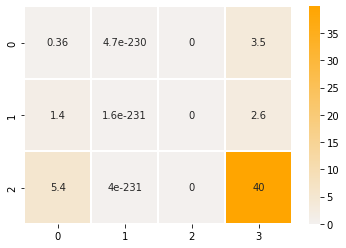

In [15]:
# Let's visualize our annotations after applying attention to them
ax = sns.heatmap(applied_attention, annot=True, cmap=sns.light_palette("orange", as_cmap=True), linewidths=1)
plt.show()

Contrast this with the raw annotations visualized earlier in the notebook, and we can see that the second and third annotations (columns) have been nearly wiped out. The first annotation maintains some of its value, and the fourth annotation is the most pronounced.

All that remains to produce our attention context vector now is to sum up the four columns to produce a single attention context vector


In [16]:
def calculate_attention_vector(applied_attention):
    return np.sum(applied_attention, axis=1)

attention_vector = calculate_attention_vector(applied_attention)
attention_vector

array([ 3.88079708,  4.0728263 , 45.26423912], dtype=float128)

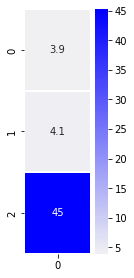

In [17]:
# Let's visualize the attention context vector
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(np.transpose(np.matrix(attention_vector)), annot=True, cmap=sns.light_palette("Blue", as_cmap=True), linewidths=1)
plt.show()

Now that we have the context vector, we can concatenate it with the hidden state and pass it through a hidden layer to produce the the result of this decoding time step.

## Transformer

Notably,
self-attention
enjoys both parallel computation and
the shortest maximum path length.
Therefore natually,
it is appealing to design deep architectures
by using self-attention.
Unlike earlier self-attention models
that still rely on RNNs for input representations,
the transformer model
is solely based on attention mechanisms
without any convolutional or recurrent layer.
Though originally proposed
for sequence to sequence learning on text data,
transformers have been
pervasive in a wide range of
modern deep learning applications,
such as in areas of language, vision, speech, and reinforcement learning.

As an instance of the encoder-decoder
architecture,
the transformer is composed of an encoder and a decoder.
Different from
Bahdanau attention
for sequence to sequence learning,
the input (source) and output (target)
sequence embeddings
are added with positional encoding
before being fed into
the encoder and the decoder
that stack modules based on self-attention.

Now we provide an overview of the
transformer architecture.
On a high level,
the transformer encoder is a stack of multiple identical layers,
where each layer
has two sublayers (either is denoted as $\mathrm{sublayer}$).
The first
is a multi-head self-attention pooling
and the second is a positionwise feed-forward network.
Specifically,
in the encoder self-attention,
queries, keys, and values are all from the
the outputs of the previous encoder layer.
Inspired by the ResNet design,
a residual connection is employed
around both sublayers.
In the transformer,
for any input $\mathbf{x} \in \mathbb{R}^d$ at any position of the sequence,
we require that $\mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$ so that
the residual connection $\mathbf{x} + \mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$ is feasible.
This addition from the residual connection is immediately
followed by layer normalization.
As a result, the transformer encoder outputs a $d$-dimensional vector representation for each position of the input sequence.

The transformer decoder is also
a stack of multiple identical layers with residual connections and layer normalizations.
Besides the two sublayers described in
the encoder, the decoder inserts
a third sublayer, known as
the encoder-decoder attention,
between these two.
In the encoder-decoder attention,
queries are from the
outputs of the previous decoder layer,
and the keys and values are
from the transformer encoder outputs.
In the decoder self-attention,
queries, keys, and values are all from the
the outputs of the previous decoder layer.
However,
each position in the decoder is
allowed to only attend to all positions in the decoder
up to that position.
This *masked* attention
preserves the auto-regressive property,
ensuring that the prediction only depends on those output tokens that have been generated.


We have already described and implemented
multi-head attention based on scaled dot-products
and positional encoding.
In the following,
we will implement the rest of the transformer model.


The positionwise feed-forward network
transforms
the representation at all the sequence positions
using the same MLP.
This is why we call it *positionwise*.
In the implementation below,
the input `X` with shape
(batch size, number of time steps or sequence length in tokens, number of hidden units or feature dimension)
will be transformed by a two-layer MLP into
an output tensor of shape
(batch size, number of time steps, `ffn_num_outputs`).


In [ ]:
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

The following example shows that the innermost dimension of a tensor changes to the number of outputs in the positionwise feed-forward network. Since the same MLP transforms at all the positions, when the inputs at all these positions are the same, their outputs are also identical.

In [ ]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.2861, -0.0025, -0.0842,  0.2562,  0.0909, -0.0013,  0.4661, -0.1367],
        [ 0.2861, -0.0025, -0.0842,  0.2562,  0.0909, -0.0013,  0.4661, -0.1367],
        [ 0.2861, -0.0025, -0.0842,  0.2562,  0.0909, -0.0013,  0.4661, -0.1367]],
       grad_fn=<SelectBackward>)

Now let us focus on the “add & norm” component. As we described at the beginning of this section, this is a residual connection immediately followed by layer normalization. Both are key to effective deep architectures.

Layer normalization is the same as batch normalization except that the former normalizes across the feature dimension. Despite its pervasive applications in computer vision, batch normalization is usually empirically less effective than layer normalization in natural language processing tasks, whose inputs are often variable-length sequences.

The following code snippet compares the normalization across different dimensions by layer normalization and batch normalization.

In [ ]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from `X` in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward>)


Now we can implement the AddNorm class using a residual connection followed by layer normalization. Dropout is also applied for regularization.

In [ ]:
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

The residual connection requires that the two inputs are of the same shape so that the output tensor also has the same shape after the addition operation.

In [ ]:
add_norm = AddNorm([3, 4], 0.5)  # Normalized_shape is input.size()[1:]
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

With all the essential components to assemble the transformer encoder, let us start by implementing a single layer within the encoder. The following EncoderBlock class contains two sublayers: multi-head self-attention and positionwise feed-forward networks, where a residual connection followed by layer normalization is employed around both sublayers.

In [ ]:
class EncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(key_size, query_size,
                                                value_size, num_hiddens,
                                                num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

As we can see, any layer in the transformer encoder does not change the shape of its input.

In [ ]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In the following transformer encoder implementation, we stack num_layers instances of the above EncoderBlock classes. Since we use the fixed positional encoding whose values are always between -1 and 1, we multiply values of the learnable input embeddings by the square root of the embedding dimension to rescale before summing up the input embedding and the positional encoding.

In [ ]:
class TransformerEncoder(d2l.Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

Below we specify hyperparameters to create a two-layer transformer encoder. The shape of the transformer encoder output is (batch size, number of time steps, num_hiddens).

In [ ]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2,
                             0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

The transformer decoder is composed of multiple identical layers. Each layer is implemented in the following DecoderBlock class, which contains three sublayers: decoder self-attention, encoder-decoder attention, and positionwise feed-forward networks. These sublayers employ a residual connection around them followed by layer normalization.

As we described earlier in this section, in the masked multi-head decoder self-attention (the first sublayer), queries, keys, and values all come from the outputs of the previous decoder layer. When training sequence-to-sequence models, tokens at all the positions (time steps) of the output sequence are known. However, during prediction the output sequence is generated token by token; thus, at any decoder time step only the generated tokens can be used in the decoder self-attention. To preserve auto-regression in the decoder, its masked self-attention specifies dec_valid_lens so that any query only attends to all positions in the decoder up to the query position.

In [ ]:
class DecoderBlock(nn.Module):
    # The `i`-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = torch.arange(1, num_steps + 1,
                                          device=X.device).repeat(
                                              batch_size, 1)
        else:
            dec_valid_lens = None

        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of `enc_outputs`:
        # (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

To facilitate scaled dot-product operations in the encoder-decoder attention and addition operations in the residual connections, the feature dimension (num_hiddens) of the decoder is the same as that of the encoder.

In [ ]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

Now we construct the entire transformer decoder composed of num_layers instances of DecoderBlock. In the end, a fully-connected layer computes the prediction for all the vocab_size possible output tokens. Both of the decoder self-attention weights and the encoder-decoder attention weights are stored for later visualization.

In [ ]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

Let us instantiate an encoder-decoder model by following the transformer architecture. Here we specify that both the transformer encoder and the transformer decoder have 2 layers using 4-head attention. We train the transformer model for sequence to sequence learning on the English-French machine translation dataset.

loss 0.031, 4512.6 tokens/sec on cuda:0


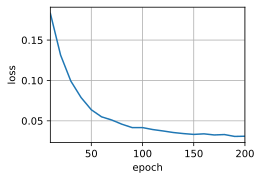

In [ ]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

After training, we use the transformer model to translate a few English sentences into French and compute their BLEU scores.

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est <unk> .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


Let us visualize the transformer attention weights when translating the last English sentence into French. The shape of the encoder self-attention weights is (number of encoder layers, number of attention heads, num_steps or number of queries, num_steps or number of key-value pairs).

In [ ]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape(
    (num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

In the encoder self-attention, both queries and keys come from the same input sequence. Since padding tokens do not carry meaning, with specified valid length of the input sequence, no query attends to positions of padding tokens. In the following, two layers of multi-head attention weights are presented row by row. Each head independently attends based on a separate representation subspaces of queries, keys, and values.

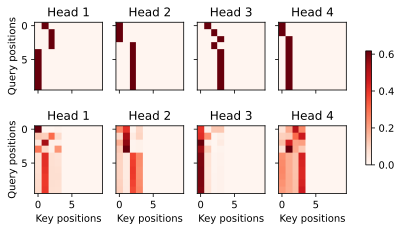

In [ ]:
d2l.show_heatmaps(enc_attention_weights.cpu(), xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))

To visualize both the decoder self-attention weights and the encoder-decoder attention weights, we need more data manipulations. For example, we fill the masked attention weights with zero. Note that the decoder self-attention weights and the encoder-decoder attention weights both have the same queries: the beginning-of-sequence token followed by the output tokens.

In [ ]:
dec_attention_weights_2d = [
    head[0].tolist() for step in dec_attention_weight_seq for attn in step
    for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape(
    (-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

Due to the auto-regressive property of the decoder self-attention, no query attends to key-value pairs after the query position.

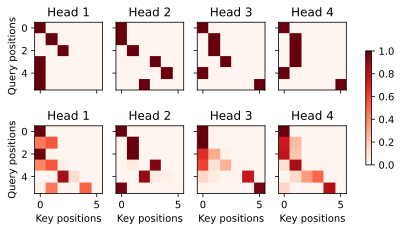

In [ ]:
# Plus one to include the beginning-of-sequence token
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

Similar to the case in the encoder self-attention, via the specified valid length of the input sequence, no query from the output sequence attends to those padding tokens from the input sequence.

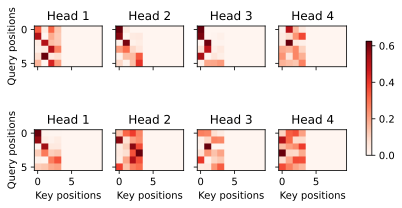

In [ ]:
d2l.show_heatmaps(dec_inter_attention_weights, xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))

Although the transformer architecture was originally proposed for sequence-to-sequence learning, as we will discover later in the book, either the transformer encoder or the transformer decoder is often individually used for different deep learning tasks.